In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems.

There are two prerequisites; the first is the `CFEDemands` python
module, which can be installed with a simple:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



## Data



Consider the case in which the data are saved in a google sheet; we&rsquo;ll
turn data from these into `pandas` dataframes.  
There are limits on the allowable size of google sheets (5 million
cells), so if your dataset is larger than this you&rsquo;ll need some other
mechanism to get your data into such dataframes.  Even in this latter
case you&rsquo;ll want your dataframes to have a structure that matches the
description given below.



### Structure of the Spreadsheet



An example spreadsheet can be found at
[https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/](https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo/).

This spreadsheet consists of two worksheets, labeled &ldquo;Expenditures&rdquo;
and &ldquo;Household Characteristics&rdquo;, respectively.

Each worksheet has the initial three columns labeled &ldquo;j&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;j&rdquo;
should include a household id; the column &ldquo;t&rdquo; should include an
indicator for the year or period (for those of you with
cross-sectional data these will all take a common value, e.g., 2019);
the column &ldquo;m&rdquo; should be an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Malawi&rdquo;).

The triple (j,t,m) will serve as the index of some constructed
dataframes.  It is important not to have **too** many different values
for &ldquo;m&rdquo; (unless you have lots of RAM to play with).

Beyond the first three columns, the &ldquo;Expenditures&rdquo; worksheet should
have one column for each category of expenditures (e.g., &ldquo;Rice&rdquo;, &ldquo;Goat
meat&rdquo;, &ldquo;Millet&rdquo;,&#x2026;).

Beyond the first three columns, the &ldquo;Household Characteristics&rdquo; should
have columns corresponding to different elements of the vector of
observable characteristics $z$.  If the data allow, I recommend
constructing observables that match what I have in the ICRISAT data:
namely numbers of &ldquo;Men&rdquo;, &ldquo;Women&rdquo;, &ldquo;Boys&rdquo; and &ldquo;Girls&rdquo;; also the
logarithm of total household size (&ldquo;log HSize&rdquo;).



### From Sheet to DataFrame to Result Object



We begin by defining a dictionary that contains the spreadsheet key. 
One is provided for the Indian ICRISAT example that I wish to work
through.



In [2]:
#https://docs.google.com/spreadsheets/d/1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk/edit#gid=1201583718

In [3]:
uganda_data = '1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk'

In [4]:
uganda_data

'1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk'

With the spreadsheet defined , grab it and define a couple of
dataframes. Note that the spreadsheet must be public for this approach
to work; if you want to keep this private consider using private
keys.



In [5]:
!pip install oauth2client

In [6]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../Project2/')
from eep153_tools import read_sheets

#### Need private keys from json file (we're authenticating using "service accounts")
!gpg --batch --passphrase "noodle octopus" -d ../students-9093fa174318.json.gpg > ../students-9093fa174318.json
####

# Add credentials if sheet not meant to be public
x = read_sheets(uganda_data,sheet='Expenditures',json_creds='../students-9093fa174318.json')
                 
# Change 'ICRISAT' to key of your own sheet in Sheets, above
z = read_sheets(uganda_data,sheet="HH Characteristics",json_creds='../students-9093fa174318.json')

# Assume a single market: (Comment this out to make each village its own market)
z['m'] = 1
x['m'] = 1


x = x.replace("NaN",np.nan) # Replace zeros with missing
x = x.replace("0",np.nan)

x = x.astype(float)



# Take logs of expenditures; call this y
y = np.log(x.set_index(['j','t','m']))

z.set_index(['j','t','m'],inplace=True)

#x.apply(pd.to_numeric, errors='ignore')



gpg: AES256 encrypted data
gpg: encrypted with 1 passphrase


This gives a dataframe of household characteristics $z$ with a simple structure.



In [7]:
z.head()

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+
j,t,m,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [8]:


z["Family Size"] = z["M 0-3"] + z["M 4-8"] + z["M 9-13"] + z["M 14-18"] + z["M 19-30"] + z["M 31-50"]+ z["M 51+"] + z["F 0-3"] + z["F 4-8"] + z["F 9-13"] + z["F 14-18"] + z["F 19-30"] + z["F 31-50"]+ z["F 51+"]



In [10]:


with_children_df  = pd.concat([z[z["M 0-3"] >0], z[z["M 4-8"] >0], z[z["M 9-13"] >0], z[z["M 14-18"] >0], z[z["F 0-3"] >0], z[z["F 4-8"] >0], z[z["F 9-13"] >0], z[z["F 14-18"] >0]]).drop_duplicates()


with_children_id = with_children_df.reset_index()["j"]



In [11]:
without_children_df = z.drop(with_children_df.index)

without_children_id = without_children_df.reset_index()["j"]



len(with_children_df)

6528

In [12]:
len(without_children_id)

5134

In [13]:
len(with_children_df) +len(without_children_id)

11662

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [14]:
y.head()

Matooke(cluster)  Matooke(others)  avocado  \
j            t      m                                                 
1.013000e+09 2005.0 1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   
                    1.0               NaN              NaN      NaN   

                         beans dry  beans fresh      beef       beer  bread  \
j            t      m                                                         
1.013000e+09 2005.0 1.0        NaN          NaN  8.699515   7.783224    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN        NaN    NaN   
                    1.0        NaN          NaN       NaN  10.150348    NaN   

                         cabbages  carrots  ...  simsim      soda  sorghum  \
j            t      m                       ...                              
1.013000e+09 2005.0 1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN       NaN      NaN   
                    1.0       NaN      NaN  ...     NaN  8.517193      NaN   

                            sugar  sweet bananas  sweet potatoes dry  \
j            t      m                                                  
1.013000e+09 2005.0 1.0  8.411833            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0       NaN            NaN                 NaN   
                    1.0  7.600902            NaN                 NaN   

                         sweet potatoes fresh       tea  tomatoes  watermelon  
j            t      m                                                          
1.013000e+09 2005.0 1.0                   NaN  3.912023  6.551080         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0                   NaN       NaN       NaN         NaN  
                    1.0              8.517193  4.605170  5.298317         NaN  

[5 rows x 74 columns]

## Estimation



With nothing more than this, we can estimate the demand system.  This
happens in two steps.  The first is the &ldquo;reduced form&rdquo; step:



In [15]:
import cfe

result = cfe.Result(y=y,z=z)

This creates a complicated &ldquo;Result&rdquo; object, with lots of different
attributes.  Note from below that attributes $y$ and $z$ are now defined.



In [16]:
result

<xarray.Result>
Dimensions:           (i: 37, j: 3737, k: 15, m: 1, t: 4)
Coordinates:
  * j                 (j) float64 1.013e+09 1.013e+09 ... 3.03e+15 3.021e+16
  * m                 (m) float64 1.0
  * t                 (t) float64 2.005e+03 2.009e+03 2.01e+03 2.011e+03
  * i                 (i) <U34 'beans dry' 'beans fresh' ... 'tea' 'tomatoes'
  * k                 (k) <U11 'M 0-3' 'M 4-8' ... 'F 51+' 'Family Size'
Data variables:
    alpha             object None
    beta              object None
    delta             object None
    prices            object None
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    loglambdas        object None
    a                 object None
    yhat              object None
    ce                object None
    cehat             object None
    e                 object None
    delta_covariance  object None
    beta_covariance   object None
    se_delta          object None
    se_beta           object None
    se_alpha          object None
    se_a              object None
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              object None
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    firstround:            2005.0
    min_proportion_items:  0.125
    min_xproducts:         30
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    verbose:               False

### First step of Estimation



Recall that there are two steps to estimation; the first step
involves estimating the &ldquo;reduced form&rdquo; linear regression 
$$
y_{it}^j = {a}_{it} + \delta_i'{z}^j_t + \epsilon_{it}^j.
$$

The Result class has code to estimate this in one line:



In [17]:
result.get_reduced_form()

/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:399: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics
/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:399: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics
/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:399: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics
/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:399: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqrt(np.diag(V[Item])), index=z.columns) # reduced form se on characteristics
/opt/conda/lib/python3.8/site-packages/cfe/estimation.py:399: RuntimeWarning: invalid value encountered in sqrt
  sed[Item]=pd.Series(np.sqr

After running this we can examine the estimated coefficients $\delta$:



In [18]:
result.delta.to_dataframe().unstack('k')

delta                              \
k                                          F 0-3       F 14-18       F 19-30   
i                                                                              
beans dry                          -5.969318e+12 -5.969318e+12 -5.969318e+12   
beans fresh                        -2.881039e-02 -2.909443e-03 -6.488669e-03   
beef                               -1.867405e+12 -1.867405e+12 -1.867405e+12   
bread                              -2.468643e+12 -2.468643e+12 -2.468643e+12   
cabbages                            8.666619e+12  8.666619e+12  8.666619e+12   
cassava dry/flour                  -1.040824e+13 -1.040824e+13 -1.040824e+13   
cassava fresh                      -6.391736e-02  3.587037e-02 -2.945893e-03   
chicken                            -5.540821e-02 -4.224712e-02  1.392068e-02   
coffee                              5.401850e+12  5.401850e+12  5.401850e+12   
cooking oil                         3.690530e+12  3.690530e+12  3.690530e+12   
dodo                               -8.342938e-02  1.135998e-02  5.779453e-02   
dry/smoked fish                    -2.934196e+12 -2.934196e+12 -2.934196e+12   
eggs                               -9.526963e+12 -9.526963e+12 -9.526963e+12   
expenditure in restaurants on food -2.472817e-01 -1.072946e-02  1.261533e-01   
fresh fish                         -1.195310e+13 -1.195310e+13 -1.195310e+13   
fresh milk                         -1.336599e+13 -1.336599e+13 -1.336599e+13   
goat meat                          -1.164007e-01 -4.386023e-03  6.124036e-02   
ground nuts pounded                 6.590179e+12  6.590179e+12  6.590179e+12   
irish potatoes                     -5.755173e+12 -5.755173e+12 -5.755173e+12   
maize cobs                          2.150451e-02  1.674708e-02 -7.103893e-02   
maize flour                        -1.450469e+13 -1.450469e+13 -1.450469e+13   
mangoes                             2.602871e-03  3.715120e-02  4.017083e-02   
margarine,butter                   -1.249050e-01 -4.974839e-02 -3.213334e-02   
matooke_1                          -8.029390e-02  4.284985e-02  1.173023e-01   
millet                              3.297296e-02 -3.237006e-02 -9.188230e-02   
onions                              2.750851e+12  2.750851e+12  2.750851e+12   
oranges                            -2.207009e-01  1.267654e-01  1.679378e-01   
other vegetables                    6.389084e+12  6.389084e+12  6.389084e+12   
passion fruits                     -4.399463e-02  7.991110e-02  1.321098e-01   
rice                               -7.201835e+12 -7.201835e+12 -7.201835e+12   
salt                               -2.087818e+12 -2.087818e+12 -2.087818e+12   
soda                               -1.581679e+13 -1.581679e+13 -1.581679e+13   
sugar                              -5.172987e-02 -7.983837e-03  1.010263e-01   
sweet bananas                       2.996158e+13  2.996158e+13  2.996158e+13   
sweet potatoes fresh               -4.216884e+12 -4.216884e+12 -4.216884e+12   
tea                                -3.059647e+12 -3.059647e+12 -3.059647e+12   
tomatoes                           -3.962780e+12 -3.962780e+12 -3.962780e+12   

                                                                              \
k                                        F 31-50         F 4-8         F 51+   
i                                                                              
beans dry                          -5.969318e+12 -5.969318e+12 -5.969318e+12   
beans fresh                         7.418200e-02 -3.876256e-02  1.165600e-01   
beef                               -1.867405e+12 -1.867405e+12 -1.867405e+12   
bread                              -2.468643e+12 -2.468643e+12 -2.468643e+12   
cabbages                            8.666619e+12  8.666619e+12  8.666619e+12   
cassava dry/flour                  -1.040824e+13 -1.040824e+13 -1.040824e+13   
cassava fresh                       8.711218e-02 -4.711401e-03  7.819777e-02   
chicken                             3.8131

Also the good-time constants $a_{it}$ (this captures the effects of prices)



In [19]:
result.a.to_dataframe().unstack('i')

a                                            \
i          beans dry beans fresh      beef     bread  cabbages   
t      m                                                         
2005.0 1.0  6.673760    6.166651  7.594869  6.548924  6.029705   
2009.0 1.0  7.186676    6.660552  8.086146  7.217766  6.327324   
2010.0 1.0  7.371394    6.874905  8.163993  7.090434  6.412728   
2011.0 1.0  7.444979    7.184067  8.396071  7.405639  6.651760   

                                                                            \
i          cassava dry/flour cassava fresh   chicken    coffee cooking oil   
t      m                                                                     
2005.0 1.0          6.908164      6.561716  8.220995  4.593350    6.159543   
2009.0 1.0          7.315575      6.985613  8.733654  4.804842    6.584684   
2010.0 1.0          7.335319      6.993906  8.798743  4.742790    6.742617   
2011.0 1.0          7.677956      7.339227  9.207515  5.081260    6.918872   

            ...                                                                \
i           ... other vegetables passion fruits      rice      salt      soda   
t      m    ...                                                                 
2005.0 1.0  ...         5.617778       6.412390  6.885402  4.370303  7.079926   
2009.0 1.0  ...         6.130105       6.691317  7.393217  5.028605  7.349360   
2010.0 1.0  ...         6.093935       6.631896  7.456423  4.963473  7.524545   
2011.0 1.0  ...         6.472194       6.896860  7.760237  5.120592  7.793919   

                                                                             
i              sugar sweet bananas sweet potatoes fresh       tea  tomatoes  
t      m                                                                     
2005.0 1.0  6.854877      5.944410             6.638204  4.612134  5.953997  
2009.0 1.0  7.196572      6.380422             7.079448  4.679546  6.412987  
2010.0 1.0  7.370396      6.393551             7.457811  4.685348  6.423180  
2011.0 1.0  7.461896      6.787567             7.329122  4.937515  6.618553  

[4 rows x 37 columns]

### Second step of Estimation



The second step involves using Singular Value Decomposition to find
the rank one matrix that best approximates the residuals $e_{it}^j$.
This can be interpreted as
$$
    -\beta_i\log\lambda^j_t,
$$
where the $\log\lambda^j_t$ is the log of the marginal utility of
expenditures (MUE) for household $j$ at time $t$, and where $\beta_i$ are
the corresponding &ldquo;Frisch elasticities&rdquo; that tell us how much
demand changes as the MUE falls.

Estimates can also be computed as a one-liner:



In [20]:
result.get_beta(as_df=True)

i
beans dry                             0.255683
beans fresh                           0.380963
beef                                  0.384099
bread                                 0.567993
cabbages                              0.357590
cassava dry/flour                     0.129863
cassava fresh                         0.314165
chicken                               0.321614
coffee                                0.630912
cooking oil                           0.483223
dodo                                  0.452543
dry/smoked fish                       0.352169
eggs                                  0.420038
expenditure in restaurants on food    0.461055
fresh fish                            0.412364
fresh milk                            0.566655
goat meat                             0.359640
ground nuts pounded                   0.367170
irish potatoes                        0.388992
maize cobs                            0.356537
maize flour                           0.285360
mangoes    

In [21]:
result.get_alpha(as_df=True)

i
beans dry                             6.673760
beans fresh                           6.166651
beef                                  7.594869
bread                                 6.548924
cabbages                              6.029705
cassava dry/flour                     6.908164
cassava fresh                         6.561716
chicken                               8.220995
coffee                                4.593350
cooking oil                           6.159543
dodo                                  5.544825
dry/smoked fish                       6.622562
eggs                                  6.220407
expenditure in restaurants on food    7.874761
fresh fish                            7.060502
fresh milk                            6.997276
goat meat                             7.402044
ground nuts pounded                   6.267511
irish potatoes                        6.697962
maize cobs                            6.026852
maize flour                           6.702911
mangoes    

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.  (This can be controlled using the
`min_proportion_items` and `min_xproducts` attributes when one
instantiates the result object.)



### Assessment of Fit



Now, let&rsquo;s see how we did, by comparing total expenditures predicted by the
model we&rsquo;ve estimated with actual total expenditures:



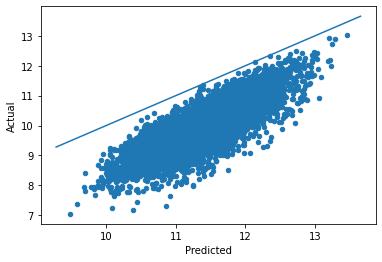

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

In [23]:
total_expend = result.get_predicted_expenditures().to_dataframe("x").unstack("i").reset_index()

In [24]:
total_expend.iloc[0]


   i                                 
j                                        1.013000e+09
t                                        2.005000e+03
m                                        1.000000e+00
x  beans dry                             1.471926e+03
   beans fresh                           1.100147e+03
   beef                                  3.909575e+03
   bread                                 1.807817e+03
   cabbages                              7.621273e+02
   cassava dry/flour                     2.031493e+03
   cassava fresh                         1.513368e+03
   chicken                               5.610566e+03
   coffee                                3.014078e+02
   cooking oil                           1.140415e+03
   dodo                                  6.576471e+02
   dry/smoked fish                       1.715776e+03
   eggs                                  1.032677e+03
   expenditure in restaurants on food    7.022645e+03
   fresh fish                            2.3

In [28]:
with_children_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000202,2005,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2
1013000210,2005,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,4
1013000213,2005,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,3
1021000113,2005,1,1,1,1,1,0,1,0,0,1,2,1,1,1,0,11
1021000203,2005,1,1,1,1,1,0,0,1,0,0,0,0,2,0,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233002609,2011,1,0,0,0,0,1,1,0,0,0,0,1,0,0,2,5
3183000309,2011,1,0,0,0,0,1,0,0,0,0,0,2,0,0,1,4
4171000802,2011,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,6


In [29]:
without_children_df

,,,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Family Size
j,t,m,,,,,,,,,,,,,,,
1013000201,2005,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1013000204,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1013000206,2005,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1013000209,2005,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1021000103,2005,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010630003050502,2011,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,3
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2


In [33]:
with_1 = pd.merge(with_children_df.reset_index()[["j"]], total_expend,  on= "j", how ="inner")

#with_1.iloc[:,[1]] = with_1.iloc[:,[1]].astype(int)


with_1

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000202,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1013000202,2009.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1013000202,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1013000202,2011.0,1.0,2882.642896,2591.934050,6098.044144,2465.091235,983.538684,4909.234457,2549.882004,...,925.899811,1354.488587,3464.155785,232.215876,2645.432140,2811.039995,1273.092124,2499.246084,223.146220,994.397930
4,1013000210,2005.0,1.0,1539.942608,1151.307010,4088.378599,1870.102530,703.737876,2843.739536,1276.083405,...,590.831246,1200.709173,2246.965947,129.334537,2405.973306,2248.233627,793.484632,1713.426539,201.095887,821.089317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,1021001301,2011.0,1.0,7795.841205,13817.215142,28366.529791,19609.992635,2877.347006,8228.490661,6097.180392,...,3578.133281,11174.184264,14064.321940,427.813366,13285.556969,14854.411169,9359.899592,6072.853431,897.327346,5299.009013
26108,104300060303,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26109,104300060303,2009.0,1.0,2845.762188,2163.311333,7614.969189,4249.410533,1157.602065,3593.583034,2296.106014,...,1416.285196,2278.299428,4243.977454,254.500741,3437.811825,3823.207958,2110.495525,2366.730031,258.929470,1723.435931
26110,104300060303,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:


pd.merge(without_children_df.reset_index()[["j"]], total_expend,on="j" ,how ="inner")

/opt/conda/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,j,"(t, )","(m, )","(x, beans dry)","(x, beans fresh)","(x, beef)","(x, bread)","(x, cabbages)","(x, cassava dry/flour)","(x, cassava fresh)",...,"(x, other vegetables)","(x, passion fruits)","(x, rice)","(x, salt)","(x, soda)","(x, sugar)","(x, sweet bananas)","(x, sweet potatoes fresh)","(x, tea)","(x, tomatoes)"
0,1013000201,2005.0,1.0,1471.925920,1100.147052,3909.575305,1807.817134,762.127322,2031.492973,1513.367545,...,641.364801,1658.590163,1975.691320,112.259797,2275.089004,2206.574025,1064.214886,1365.058944,203.832219,887.166112
1,1013000201,2009.0,1.0,2961.353214,1891.685914,6331.257629,2405.141781,873.742256,5132.056662,2659.749756,...,907.737948,1363.960404,3568.585669,274.384500,2311.967815,3099.105177,1081.406943,3122.265860,213.102604,1051.689529
2,1013000201,2010.0,1.0,4182.947451,2622.847655,8143.343238,3091.262668,1227.039298,6062.362920,3319.680800,...,1105.473164,1599.513495,4321.204514,277.324380,3316.126189,4349.446985,1599.978474,4087.349126,241.620263,1329.589801
3,1013000201,2011.0,1.0,3739.996750,2979.977102,7638.907957,2699.528258,1130.977926,7909.926471,3748.685610,...,1084.830985,1526.792125,4296.535254,289.939554,3053.908787,3485.886433,1460.459882,3678.778973,255.816885,1145.216405
4,1013000201,2005.0,1.0,1471.925920,1100.147052,3909.575305,1807.817134,762.127322,2031.492973,1513.367545,...,641.364801,1658.590163,1975.691320,112.259797,2275.089004,2206.574025,1064.214886,1365.058944,203.832219,887.166112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,3010730016100203,2011.0,1.0,2028.305736,1629.801928,4762.850096,1789.861132,721.603483,3604.969151,1615.018118,...,621.197449,922.314372,2352.313488,188.387194,2620.230299,1953.371096,695.579667,1831.058631,176.095766,781.389735
20528,3030230010040204,2005.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20529,3030230010040204,2009.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20530,3030230010040204,2010.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Saving Result



You can save the estimated result, using something like



In [ ]:
result.to_dataset('icrisat.ds')